In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 8.0MB/s 
     |████████████████████████████████| 3.3MB 53.4MB/s 
     |████████████████████████████████| 901kB 51.1MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline
#%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")
  print(device)

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Skripsi/datasetBeritaFIX.csv')
train_df = pd.read_csv('/content/drive/MyDrive/Skripsi/train_berita.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Skripsi/test_berita.csv')

In [ ]:
class_names = ['edukasi', 'tekno', 'sports', 'health', 'lifestyle']
test_df['list_kategori'] = list(test_df[class_names].values)
train_df['list_kategori'] = list(train_df[class_names].values)

In [ ]:
train_df=train_df.drop(columns=class_names)
test_df=test_df.drop(columns=class_names)

In [ ]:
test_df

In [ ]:
PRE_TRAINED_MODEL_BAHASA =  'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_BAHASA)

MAX_LEN = 400

In [ ]:
#Classify
class DatasetBerita(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
val_df, test_df = train_test_split(
  test_df,
  test_size=0.5, # tes 50% val 50%
  random_state=RANDOM_SEED
)

In [ ]:
val_df

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DatasetBerita(
    reviews=df.preprocessing_text.to_numpy(), #berdasarkan table di df
    targets=df.list_kategori.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Klasifikasi(nn.Module):

  def __init__(self, n_classes):
    super(Klasifikasi, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = Klasifikasi(len(class_names))
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * 1
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
model = model.train()
losses = []
correct_predictions = 0
for d in train_data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    loss.backward()
    print(f'loss {np.mean(losses)} acc {correct_predictions.double() / len(train_df)}')
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 1.6153987646102905 acc 0.0007925500297206261
loss 1.6514875888824463 acc 0.0015851000594412521
loss 1.6425571044286091 acc 0.002575787596592035
loss 1.5315076112747192 acc 0.004359025163463443
loss 1.5086069583892823 acc 0.005547850208044382
loss 1.5933138132095337 acc 0.006142262730334852
loss 1.575071164539882 acc 0.007331087774915791
loss 1.5608262568712234 acc 0.008321775312066574
loss 1.5994464423921373 acc 0.009510600356647513
loss 1.5870334267616273 acc 0.010897562908658608
loss 1.5719547271728516 acc 0.012284525460669705
loss 1.5556395451227825 acc 0.014067763027541112
loss 1.5169248764331524 acc 0.016049138101842678
loss 1.545971495764596 acc 0.016247275609272836
loss 1.5801183541615804 acc 0.01703982563899346
loss 1.570292942225933 acc 0.0182286506835744
loss 1.5516383297303145 acc 0.019615613235585496
loss 1.5355081492000155 acc 0.02120071329502675
loss 1.5365213093004728 acc 0.022587675847037844
loss 1.521555757522583 acc 0.02437091341390925
loss 1.507770606449672 acc 

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
#TESTTTTTTTTTTTTTTTTTTTT
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler
):
  model = model.train()

  losses = []
  #correct_predictions = 0

  pred_labels = []
  true_labels = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #_, preds = torch.max(outputs, dim=1)
    
    loss = loss_fn(outputs, torch.max(targets.float(), 1)[1])

    outputs = F.softmax(outputs,dim=1)
    #correct_predictions += torch.sum(torch.max(outputs, 1)[1] == torch.max(targets, 1)[1])

    b_probs = outputs.detach().cpu().numpy()
    b_targets = targets.detach().cpu().numpy()

    true_labels.append(b_targets)
    pred_labels.append(b_probs)

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    #print(f'train acc {correct_predictions.double() / n_examples} acc1 {accuracy_score(true_bools, pred_bools)} loss {np.mean(losses)} ')
  
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]

  return accuracy_score(true_bools, pred_bools), np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []
  #correct_predictions = 0

  pred_labels = []
  true_labels = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      #_, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, torch.max(targets.float(), 1)[1])

      outputs = F.softmax(outputs,dim=1)
      #correct_predictions += torch.sum(torch.max(outputs, 1)[1] == torch.max(targets, 1)[1])

      b_probs = outputs.detach().cpu().numpy()
      b_targets = targets.detach().cpu().numpy()

      true_labels.append(b_targets)
      pred_labels.append(b_probs)
      losses.append(loss.item())

      #print(f'val acc {correct_predictions.double() / n_examples} acc1 {accuracy_score(true_bools, pred_bools)} loss {np.mean(losses)} ')

  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]

  return accuracy_score(true_bools, pred_bools), np.mean(losses)

In [ ]:
#%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'softmax_layer_2e-5_0.3_{EPOCHS}.bin')
    best_accuracy = val_acc

Epoch 1/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.34686849611115794 accuracy 0.8779472954230236
Val   loss 0.20202611499698833 accuracy 0.9413629160063391
Epoch 2/6
----------
Train loss 0.16418513069717697 accuracy 0.9502674856350307
Val   loss 0.13325684594456105 accuracy 0.9572107765451664
Epoch 3/6
----------
Train loss 0.0980572825875369 accuracy 0.9724588864672082
Val   loss 0.18222923997818724 accuracy 0.9540412044374009
Epoch 4/6
----------
Train loss 0.05671000390522082 accuracy 0.984743411927878
Val   loss 0.18400868690077915 accuracy 0.96513470681458
Epoch 5/6
----------
Train loss 0.029082776750386338 accuracy 0.9938577372696652
Val   loss 0.21059459558382515 accuracy 0.9587955625990491
Epoch 6/6
----------
Train loss 0.014668625325669647 accuracy 0.9966316623736874
Val   loss 0.2159737174260954 accuracy 0.9572107765451664


In [ ]:
text = ''

In [ ]:
#%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_acc1, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} accuracy1 {train_acc1}')

  val_acc, val_acc1, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc} accuracy1 {val_acc1}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  #if val_acc > best_accuracy:
  torch.save(model.state_dict(), 'best_model_state.bin')
  #  best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train acc 0.0005944125222904696 loss 1.7766920328140259 
train acc 0.0007925500297206261 loss 1.8515344262123108 
train acc 0.0017832375668714088 loss 1.7463825543721516 
train acc 0.0037646126411729737 loss 1.6085949838161469 
train acc 0.00515157519318407 loss 1.5281674146652222 
train acc 0.006340400237765009 loss 1.4791565537452698 
train acc 0.008718050326926886 loss 1.420974680355617 
train acc 0.011690112938379234 loss 1.297740489244461 
train acc 0.01426590053497127 loss 1.2209632131788466 
train acc 0.016841688131563302 loss 1.1439212322235108 
train acc 0.019219338220725184 loss 1.0935175852342085 
train acc 0.021993263324747374 loss 1.0377427662412326 
train acc 0.024965325936199722 loss 0.9788950154414544 
train acc 0.027739251040221912 loss 0.9424300470522472 
train acc 0.030513176144244102 loss 0.9014499167601268 
train acc 0.03308896374083614 loss 0.8814006354659796 
train acc 0.03566475133742817 loss 0.8503478818080005 
train acc 0.0378442639191599 loss 0.85199066831005

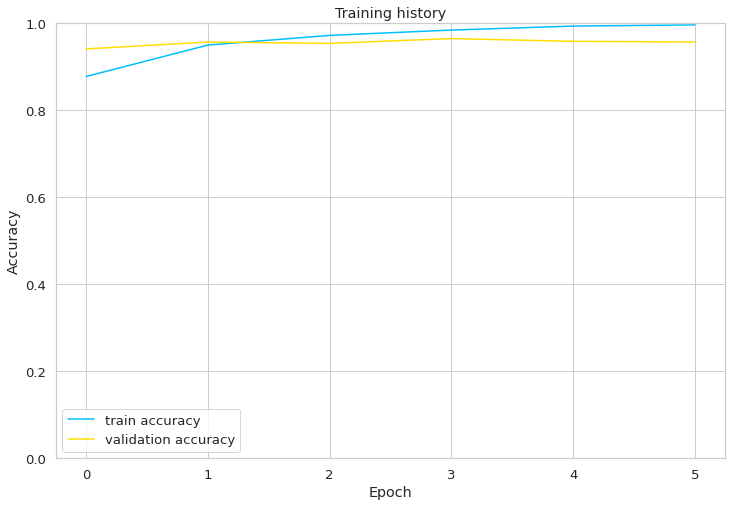

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

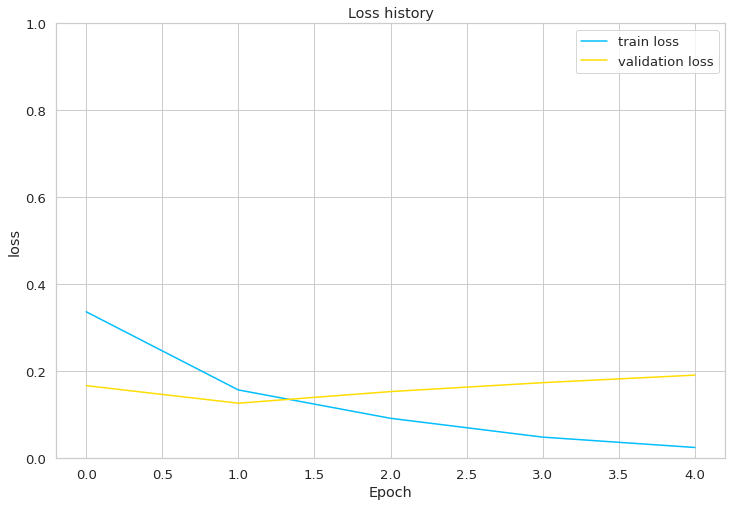

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9572107765451664

In [ ]:
"""isi_berita = '''
Indonesia membutuhkan pendidikan sejak kecil, karena dengan adanya pendidikan orang-orang indonesia dapat lebih menemukan inovasi-inovasi terbaik dan memberikan ide-ide yang sangat menarik
dengan perkembangan teknologi, pendidikan sangat mudah didapatkan. korona tidak dapat menjadi penghalang seseorang untuk mendapatkan pendidikan. dengan adanya hp memudahkan untuk mendapatkan pendidikan dimana saja dan kapan saja
'''"""

model = model.eval()
preds_label = []
encoded_review = tokenizer.encode_plus(
  isi_berita,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

In [ ]:
prob = F.softmax(output, dim=1)

In [ ]:
prob

tensor([[3.3076e-04, 9.9649e-01, 4.7558e-05, 2.6333e-03, 5.0014e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
temp_labels=[]
for a in range(len(prob)):
    text = ""

    indeks = 0
    for b in range(len(prob[a])):
      if(prob[a][b]>0.5):
        indeks+=1
        if indeks==1:
          text += "%s"%(class_names[b])
        else:
          text += ", %s"%(class_names[b])
        #print(text)
    temp_labels.append(text)

In [ ]:
temp_labels

['tekno']

In [ ]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
outputs = eval_model_test_multilabel(
  model,
  test_data_loader,
  loss_fn,
  device
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
outputs

(0.22659968249499798, 0.7654516640253566)

In [ ]:
test_data_loader.shape

AttributeError: ignored

In [ ]:
outputs

(0.22659968249499798, 0.7654516640253566)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
def get_predictions2(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      prob = F.sigmoid(outputs)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(prob)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
def get_predictions_text(model, text, max_len, threshold):
  model = model.eval()
  preds_label = []
  encoded_review = tokenizer.encode_plus(
    text,
    max_length=max_len,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  #_, preds = torch.max(output, dim=1)
  probs = F.sigmoid(output)
  probs = probs.detach().cpu().numpy()
  for a in range(len(probs[0])):
    if(probs[0][a]>threshold):
      preds_label.append(class_names[a])
  return preds_label

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred_probs>0.5, target_names=class_names))
#print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     edukasi       1.00      0.93      0.97        91
       tekno       0.95      0.95      0.95        95
      sports       0.99      0.99      0.99       224
      health       0.79      0.92      0.85        36
   lifestyle       0.94      0.94      0.94       185

   micro avg       0.96      0.96      0.96       631
   macro avg       0.93      0.95      0.94       631
weighted avg       0.96      0.96      0.96       631
 samples avg       0.96      0.96      0.96       631



In [ ]:
idx = 192
review_text = y_review_texts[idx]
class_ids = y_test[idx]
class_pred = y_pred[idx]
predprobs = y_pred_probs[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
#250 269
isi_berita = '''hp keluaran apple adalah iphone. olahraga sangat menyenangkan dan menyehatkan'''
predstext = get_predictions_text(model, isi_berita , MAX_LEN, 0.5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(predstext)

#for a in range(len(predstext)):
#  index = 0
#  print(class_names[index])
#  index+=1
  #if (float(class_names[a])>threshold):
  #  print(class_names[a])

['tekno', 'lifestyle']


In [ ]:
predstext[0]

array([0.08990626, 0.17553002, 0.99940014, 0.05432682, 0.17469932],
      dtype=float32)

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[class_ids]}')
print(class_names)
print(class_ids)
print(class_pred)
print(predprobs)

timnas u indonesia harus tel pil pahit turnamen piala asia u tahun
resmi batal konfederasi sepak bola asia afc afc resmi batal piala asia
u konfirmasi lalu surat kirim satu sepak bola seluruh indonesia pssi
jumat adapun faktor buat turnamen sebut batal wabah covid landa
seluruh dunia piala asia u kemudian ganti nama jadi piala asia u
langsung tahun uzbekistan tetap jadi tuan rumah dengan batal kompetisi
main timnas u rasa kecewa apalagi skuad garuda muda laku rangkai pusat
latih tc mentas turnamen sepak bola antarnegara asia itu namun main
minta tak tak patah semangat jalan karier bagas kaffa dkk indonesia
panjang lebih ada beberapa turnamen tingkat usia lain bisa ikut main
pasuk level timnas senior kami coba terus beri motivasi karier masih
panjang kata asisten latih timnas u nova arianto kutip bolasportcom
sabtu banyak event akan hadir mereka main timnas u lanjut mereka akan
ikut saat sampai level timnas senior jelas pria usia tahun itu belum
ajang piala dunia u langsung indonesia te

# **LOAD BERT MODEL**

In [ ]:
class_names = ['edukasi', 'tekno', 'sports', 'health', 'lifestyle']
class Klasifikasi(nn.Module):

  def __init__(self, n_classes):
    super(Klasifikasi, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_BAHASA)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
PRE_TRAINED_MODEL_BAHASA =  'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_BAHASA)

MAX_LEN = 400
BATCH_SIZE = 16

In [ ]:


#model = model.to(device)
model = Klasifikasi(len(class_names))
model.load_state_dict(torch.load("/content/drive/MyDrive/Skripsi/model/isiberita_epoch4.bin", map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
model.to(device)

Klasifikasi(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
isi_berita = '''
timnas u indonesia harus tel pil pahit turnamen piala asia u tahun
resmi batal konfederasi sepak bola asia afc afc resmi batal piala asia
u konfirmasi lalu surat kirim satu sepak bola seluruh indonesia pssi
jumat adapun faktor buat turnamen sebut batal wabah covid landa
seluruh dunia piala asia u kemudian ganti nama jadi piala asia u
langsung tahun uzbekistan tetap jadi tuan rumah dengan batal kompetisi
main timnas u rasa kecewa apalagi skuad garuda muda laku rangkai pusat
latih tc mentas turnamen sepak bola antarnegara asia itu namun main
minta tak tak patah semangat jalan karier bagas kaffa dkk indonesia
panjang lebih ada beberapa turnamen tingkat usia lain bisa ikut main
pasuk level timnas senior kami coba terus beri motivasi karier masih
panjang kata asisten latih timnas u nova arianto kutip bolasportcom
sabtu banyak event akan hadir mereka main timnas u lanjut mereka akan
ikut saat sampai level timnas senior jelas pria usia tahun itu belum
ajang piala dunia u langsung indonesia telah putus tunda hingga adapun
indonesia masih akan tindak tuan rumah piala dunia u abdul rohman
'''
model = model.eval()
preds_label = []
encoded_review = tokenizer.encode_plus(
  isi_berita,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

In [ ]:
predstext

['tekno', 'lifestyle']

In [ ]:
def get_predictions_test(model, data_loader):
  model = model.eval()
  temp = []
  real_values = []
  probs_labels = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      real_values.extend(targets)
      probs_labels.extend(F.sigmoid(outputs))
  
  probs_labels = torch.stack(probs_labels).cpu()
  real_values = torch.stack(real_values).cpu()

  return probs_labels, real_values

In [ ]:
y_pred_probs, y_test = get_predictions_test(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
def SubmissionTest(df, y_pred_prob):
  temp_labels=[]
  for a in range(len(y_pred_prob)):
    text = ""

    indeks = 0
    for b in range(len(y_pred_prob[a])):
      if(y_pred_prob[a][b]>0.5):
        indeks+=1
        if indeks==1:
          text += "%s"%(class_names[b])
        else:
          text += ", %s"%(class_names[b])
        #print(text)
    temp_labels.append(text)

  test_df['y_true_prediction'] = temp_labels
  
  test_df.drop(columns='kategori_int')
  test_df.to_csv('submission.csv', index=False, encoding='utf-8')

    

In [ ]:
SubmissionTest(test_df, y_pred_probs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y_pred_probs[0]

tensor([0.0041, 0.6452, 0.0010, 0.0017, 0.6047])